In [1]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pygame

In [2]:
class RoboticArmEnv(gym.Env):
    metadata = {'render.modes': ['human']}
    
    def __init__(self):
        super(RoboticArmEnv, self).__init__()

        self.steps_done = 0
        self.max_steps = 200
        self.action_space = spaces.Box(low=-np.pi, high=np.pi, shape=(2,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-np.pi, high=np.pi, shape=(4,), dtype=np.float32)
        
        self.angle1 = 0.0  
        self.angle2 = 0.0  
        self.length1 = 1.0  #main arm
        self.length2 = 0.5  #upper arm
        self.prev_angle1 = self.angle1
        self.prev_angle2 = self.angle2
        self.end_effector_x = self.length1 * np.cos(self.angle1) + self.length2 * np.cos(self.angle1 + self.angle2)
        self.end_effector_y = self.length1 * np.sin(self.angle1) + self.length2 * np.sin(self.angle1 + self.angle2)
        
        self.last_action = np.array([0, 0]) 

        
        self.reward_history = [] 
        self.smoothing_window_size = 20 
        self.state = np.array([self.angle1, self.angle2, self.end_effector_x, self.end_effector_y], dtype=np.float32)

    def reset(self, seed=None, **kwargs):
        if seed is not None:
            self.np_random, _ = gym.utils.seeding.np_random(seed) 

        self.angle1 = np.random.uniform(0.5 * np.pi, 1.5 * np.pi)
        self.angle2 = np.random.uniform(0.5 * np.pi, 1.5 * np.pi) 

        self.angle1 = np.clip(self.angle1, 0, np.pi)
        self.angle2 = np.clip(self.angle2, 0, np.pi)

        self.prev_angle1 = self.angle1
        self.prev_angle2 = self.angle2
        self.last_action = np.array([0, 0])

        self.end_effector_x = self.length1 * np.cos(self.angle1) + self.length2 * np.cos(self.angle1 + self.angle2)
        self.end_effector_y = self.length1 * np.sin(self.angle1) + self.length2 * np.sin(self.angle1 + self.angle2)

        self.steps_done = 0 

        self.state = np.array([self.angle1, self.angle2, self.end_effector_x, self.end_effector_y], dtype=np.float32)
        
        return self.state, {} 


    
    def reward_function(self):
        angle1_deviation = abs(self.angle1 - np.pi/2)
        angle1_reward = -5*np.exp(angle1_deviation) 
        
        if angle1_deviation < 0.02:
            angle1_reward += 0.3

        
        if angle1_deviation > 0.01:
            correction_reward = -0.1 * angle1_deviation
            angle1_reward += correction_reward
        else:
            correction_reward = 0
            angle1_reward += correction_reward


        combined_angle_deviation =abs((self.angle1 + self.angle2) - np.pi/2)
        combined_angle_reward = -2 * (combined_angle_deviation ** 2) 
        stability_reward=0.3 if angle1_deviation < 0.05 and combined_angle_deviation < 0.05 else 0
        action_penalty=  -0.1 * (abs(self.last_action[0]) + abs(self.last_action[1]))
        jerk_penalty = -0.3 * (abs(self.angle1 -self.prev_angle1) +abs(self.angle2 -self.prev_angle2))
        adaptive_penalty= -1.5 * (np.exp(angle1_deviation) + np.exp(combined_angle_deviation)) if angle1_deviation > 0.1 else 0
            

        if self.steps_done > 50:  
            time_penalty= -0.5 * (angle1_deviation + combined_angle_deviation)
        else:
            time_penalty=0
    
        total_reward= angle1_reward+combined_angle_reward+stability_reward+jerk_penalty+action_penalty+adaptive_penalty+time_penalty
    
        scaled_reward =total_reward/(np.pi**2)
        self.reward_history.append(scaled_reward)

        smoothed_reward = self.smooth_reward(self.reward_history, self.smoothing_window_size)
        
        return smoothed_reward
        

    def smooth_reward(self, reward_history, window_size=10):
        if len(reward_history) < window_size:
            return np.mean(reward_history)

        return np.mean(reward_history[-window_size:])

    
    

    def step(self, action):
        action = np.clip(action, -0.05, 0.05)
        
        self.angle1 += action[0]
        self.angle2 += action[1]

        self.angle1 = np.clip(self.angle1, 0, np.pi)
        self.angle2 = np.clip(self.angle2, 0, np.pi)

        self.end_effector_x = self.length1 * np.cos(self.angle1) + self.length2 * np.cos(self.angle1 + self.angle2)
        self.end_effector_y = self.length1 * np.sin(self.angle1) + self.length2 * np.sin(self.angle1 + self.angle2)

        self.state = np.array([self.angle1, self.angle2, self.end_effector_x, self.end_effector_y], dtype=np.float32)
        
        reward = self.reward_function()

        self.steps_done +=1

        terminated = False
        truncated = self.steps_done >= self.max_steps
        
        self.prev_angle1 = self.angle1
        self.prev_angle2 = self.angle2

        self.last_action = action

        info = {}

        return self.state, reward, terminated, truncated, info
        

    def render(self, mode='human'):

        if mode != 'human':
            raise NotImplementedError("Only human mode is supported.")
            
        """Renders the environment using Pygame."""
        # Initialize Pygame if not already done
        if not hasattr(self, 'screen'):
            pygame.init()
            self.screen = pygame.display.set_mode((600, 600))
            pygame.display.set_caption('Robotic Arm Simulation')
            self.clock = pygame.time.Clock()

        # Clear the screen
        self.screen.fill((255, 255, 255))  # White background

        # Define the center of the base
        base_x, base_y = 300, 300  # Center of the window

        # Calculate joint positions
        joint1_x = base_x + int(self.length1 * 100 * np.cos(self.angle1))
        joint1_y = base_y - int(self.length1 * 100 * np.sin(self.angle1))

        joint2_x = joint1_x + int(self.length2 * 100 * np.cos(self.angle1 + self.angle2))
        joint2_y = joint1_y - int(self.length2 * 100 * np.sin(self.angle1 + self.angle2))

        # Draw the base
        pygame.draw.circle(self.screen, (0, 0, 0), (base_x, base_y), 5)  # Black circle for the base

        # Draw the first segment
        pygame.draw.line(self.screen, (0, 0, 255), (base_x, base_y), (joint1_x, joint1_y), 5)  # Blue line

        # Draw the second segment
        pygame.draw.line(self.screen, (255, 0, 0), (joint1_x, joint1_y), (joint2_x, joint2_y), 5)  # Red line

        # Draw the end-effector
        pygame.draw.circle(self.screen, (0, 255, 0), (joint2_x, joint2_y), 5)  # Green circle for the end-effector

        # Update the display
        pygame.display.flip()

        # Limit the frame rate
        self.clock.tick(30)

    def close(self):
        """Closes the Pygame window and releases resources."""
        if hasattr(self, 'screen'):
            pygame.quit()
            del self.screen



In [3]:
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
import pandas as pd

In [4]:
env = RoboticArmEnv()
env.reset(seed=42)
logFile = './training_log'
env = Monitor(env, logFile)

model = PPO(
    "MlpPolicy", env,verbose=1, 
    learning_rate=0.00005,
    gamma=0.99,
    ent_coef=0.01,
    clip_range=0.2
)

model.learn(total_timesteps=105000)

Using cpu device
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 200       |
|    ep_rew_mean     | -1.91e+03 |
| time/              |           |
|    fps             | 1093      |
|    iterations      | 1         |
|    time_elapsed    | 1         |
|    total_timesteps | 2048      |
----------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 200         |
|    ep_rew_mean          | -2.06e+03   |
| time/                   |             |
|    fps                  | 847         |
|    iterations           | 2           |
|    time_elapsed         | 4           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.002513179 |
|    clip_fraction        | 0.000732    |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.84       |
|    expla

[-2062.404508, -1591.6971626, -1100.9695897999998, -889.35849215, -781.5976947500001, -737.4635495, -758.5542697000002, -705.6224887000001, -681.13664795, -637.1993570000001, -645.7494906000001, -608.2601927000001, -557.4979827999999, -546.4227992000001, -522.4133091000001, -426.27094189999997, -364.7796043, -396.54009765, -382.42703685, -341.4713137, -376.60178720000005, -362.9526825000001, -355.06617014999995, -381.15111265, -360.79915475, -329.41065109999994, -336.12832583333335]


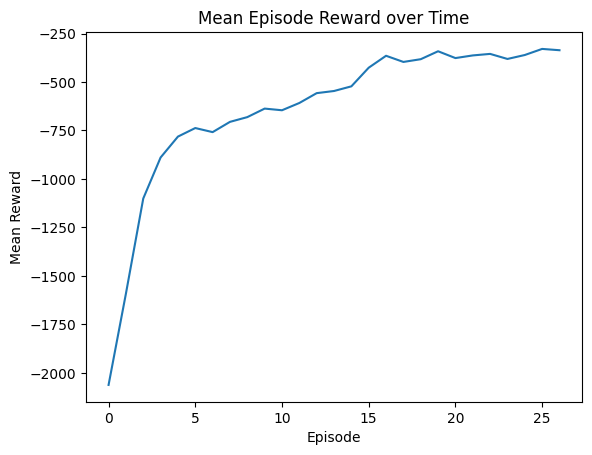

In [5]:
log_df = pd.read_csv(f"{logFile}.monitor.csv", skiprows=1)
ep_rew = log_df['r'].tolist()
ep_rew_mean =[]
for i in range(0, len(ep_rew), 20):
    chunk = ep_rew[i:i+20]
    mean_value = np.mean(chunk)
    ep_rew_mean.append(mean_value)
    
print(ep_rew_mean)

if ep_rew_mean:
    plt.plot(ep_rew_mean)
    plt.title('Mean Episode Reward over Time')
    plt.xlabel('Episode')
    plt.ylabel('Mean Reward')
    plt.show()
else:
    print("No rewards collected during training.")

In [6]:
model.save("rob_arm_PPO34")

In [7]:
del model

In [4]:
env = RoboticArmEnv()
model = PPO.load("rob_arm_PPO34")

In [5]:
from gym.wrappers import TimeLimit

In [6]:
timed_env = TimeLimit(env, max_episode_steps=200)

for episode in range(5):
    obs, _ = timed_env.reset(seed=42)
    score = 0
    offset=0.3
    
    done = False
    while not done:
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = timed_env.step(action)
        timed_env.render()
        reward+=offset
        score += reward  
        if terminated or truncated:
            print(f"Episode {episode + 1}: Score = {score:.2f}")
            break  
            
timed_env.close()

Episode 1: Score = -479.98
Episode 2: Score = -270.59
Episode 3: Score = -162.35
Episode 4: Score = -310.55
Episode 5: Score = -310.55
